Testing surface oil beaching using [Parcels](https://oceanparcels.org)

In [1]:
import sys
import os
import math
import xarray as xr
from pathlib import Path
from pprint import pprint
from parcels import AdvectionRK4, VectorField, Variable
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field, ParcelsRandom
import numpy as np
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times
# from util.parse_wildcards import parse_wildcards

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_1d23a875-a0a6-4847-8b87-385ce7ea536d.so


Are we currently deleting beached particles?

In [4]:
afile = xr.open_dataset('BoxParticles_5b_Turn_Point_Diluted_bitumen_2018-01-01.nc', decode_cf=True)

time = np.ma.filled(afile.variables['t'], np.nan)
oil = np.ma.filled(afile.variables['oil'], np.nan)

oil = oil.sum(axis=1)
oil

array([ 53., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.,  96.,   0.,   0.])

Does not appear that we are deleting particles that are beached, only particles that go outside of the model domain.

In [2]:
# Spill release times
release_start_time = '2020-07-01'  ## winter start on December, Summer Jul - Aug  ## ask Susan about when to do simulation
release_end_time = '2020-07-02'
release_YYYY = '2020-07'

Select the location of interest, which is specified by a shapefile.

In [3]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel"}
print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 4a_ActivePass_Diesel


In [4]:
#Kernels

def Beaching(particle, fieldset, time):
    '''Beaching prob'''  
    if particle.beached == 0: #Check particle is in the water column       
        Tb = particle.Lb*86400 #timescale beaching in seconds
        x_offset = particle.Db/(111319.5*math.cos(particle.lat*(math.pi/180))) #Checking distance x of possible beaching
        y_offset = particle.Db/111319.5 #Checking distance y of possible beaching
        Pb = 1 - math.exp(-particle.dt/Tb)
        if particle.lat < 48.6 and particle.lon < -124.7 or particle.lat < 49.237 and particle.lon > -123.196 and particle.lat > 49.074:
            pass #Dont let particles beach inside the fraser river
        elif ParcelsRandom.uniform(0,1)<Pb:
            DWS1 = fieldset.U[time, 0.5, particle.lat+y_offset, particle.lon+x_offset] #particle.depth 0.5 check surface beach
            DWS2 = fieldset.U[time, 0.5, particle.lat-y_offset, particle.lon+x_offset]  
            DWS3 = fieldset.U[time, 0.5, particle.lat-y_offset, particle.lon-x_offset]
            DWS4 = fieldset.U[time, 0.5, particle.lat+y_offset, particle.lon-x_offset]
            if DWS1 == 0 or DWS2 == 0 or DWS3 == 0 or DWS4 == 0:
                particle.beached = 1

def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this need to be add to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2

def BeachTesting(particle, fieldset, time):
    """ Testing if particles are on land. if 'yes' particle will be beached"""
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        #print(u, v)
        if u == 0 and v == 0:
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(0 * dt/field_decay_value) # -0.099 for diesel, 0 for other oils
    particle.decay_value = particle.decay_value * decay

In [5]:
# Data Paths
currents = Path('/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/')
winds = Path('/ocean/rlovindeer/Atlantis/Physics/Wind/')
sea_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc')
air_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc')

In [6]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
# u_data_path = currents + '2018-01*URaw_variables.nc'
# v_data_path = currents + '2018-01*VRaw_variables.nc'
# u_current = parse_wildcards(u_data_path, 'u')
# v_current = parse_wildcards(v_data_path, 'v')

u_current = sorted([p for p in currents.glob(str(release_YYYY) + '*URaw_variables.nc')])
v_current = sorted([p for p in currents.glob(str(release_YYYY) + '*VRaw_variables.nc')])

filenames = {
    'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
    'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
print('creating from_nemo')
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
print('creating from_nemo done')

fieldset.add_constant('decay', 1.0 * 3600.0)
print('add_constant decay')

creating from_nemo
creating from_nemo done
add_constant decay


In [7]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_paths = sorted([p for p in winds.glob(str(release_YYYY) + '*Wind_variables.nc')])
wind_filenames = {'lon': os.fspath(air_grid),'lat': os.fspath(air_grid),'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

pprint(wind_filenames)

{'data': [PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-06_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-12_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-18_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-24_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-30_Wind_variables.nc')],
 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc',
 'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'}


In [8]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [9]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [10]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 1
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [11]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    Lb = Variable('Lb', initial = 0.23)  #days needed in days for particle to have 67% probability of beaching if in beaching zone (500m)
    Db = Variable('Db', initial = 33) #Distance at which particles can randomly beach.
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 100
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario[file_id] + ".shp"
release_depth = -0.1
release_start_time = np.datetime64(release_start_time)
release_end_time = np.datetime64(release_end_time)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time)
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth)

#print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle)
beaching_kernel = pset.Kernel(Beaching)
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4)

# Adding to the main kernel
my_kernel = AdvectionRK4 + decay_kernel + ForcingWind_kernel + beaching_kernel

output_file_name = scenario[file_id] + str(release_start_time) +  '_OP_BeachTest.nc'
print(output_file_name)

setting up particles
-261000.0
100
100
Using shapefile /ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/4a_ActivePass_Diesel.shp
Number of sites :  1
Up to 0 of 1
80
100
Sucessfully seeded particles

num_attempts = 2
[-123.32403064543979, -123.32363758365186, -123.32390318925178, -123.32403993079495, -123.32432633198637, -123.32380129319337, -123.32429341676261, -123.32322040607549, -123.32442133557467, -123.32345676867352, -123.32407770295279, -123.32398521220445, -123.3231404979732, -123.32512137107815, -123.32336015498268, -123.32348882365507, -123.32327181593435, -123.32343920702107, -123.32423697172636, -123.32348321881713, -123.3250477909398, -123.32381540457999, -123.32309543985072, -123.32409435049028, -123.32434757755242, -123.32470220268104, -123.3234980918599, -123.32424956152181, -123.32398429227861, -123.32528282265757, -123.32386805397202, -123.32388114164941, -123.32386971126124, -123.3230976153252, -123.3237164178352, -123.32447787857701, -123.3242

In [12]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove '4a_ActivePass_Diesel2020-07-01_OP_BeachTest.nc': No such file or directory


INFO: Temporary output files are stored in out-MMIXKEJT.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MMIXKEJT" to convert these to a NetCDF file during the run.
N/A% (0 of 604800.0) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--
 21% (129600.0 of 604800.0) |##          | Elapsed Time: 0:00:00 ETA:   0:00:00
 22% (133200.0 of 604800.0) |##          | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (136800.0 of 604800.0) |##          | Elapsed Time: 0:00:00 ETA:   0:00:02
 23% (140400.0 of 604800.0) |##          | Elapsed Time: 0:00:00 ETA:   0:00:02
 23% (144000.0 of 604800.0) |##          | Elapsed Time: 0:00:00 ETA:   0:00:03
 24% (147600.0 of 604800.0) |##          | Elapsed Time: 0:00:01 ETA:   0:00:03
 25% (151200.0 of 604800.0) |###         | Elapsed Time: 0:00:01 ETA:   0:00:04
 25% (154800.0 of 604800.0) |###         | Elapsed Time: 0:00:01 ETA:   0:00:04
 26% (158400.0 of 604800.0) |###         | Elapsed Time: 0:00:01 ETA:   0:00:04
 26% (162000.0 of 604800.0)

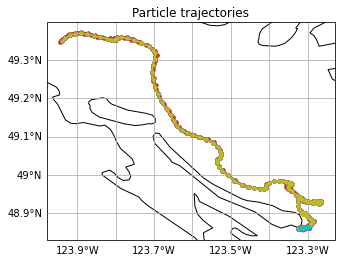

particle trajectories completed


In [13]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*7),   # the total length of the run
             dt = timedelta(minutes = 60),      # the timestep of the kernel
             output_file = output_file)  # the file name and the time step of the outputs
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')